In [1]:
#https://www.datascience.com/blog/python-anomaly-detection
from __future__ import division
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# 1. Download sunspot dataset and upload the same to dataset directory
#    Load the sunspot dataset as an Array
!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = loadtxt("dataset/sunspots.txt", float)

# 2. View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.head()

Continuing in background, pid 7124.
Output will be written to ‘wget-log.1’.


,Months,SunSpots
0,0.0,58.0
1,1.0,62.6
2,2.0,70.0
3,3.0,55.7
4,4.0,85.0


In [20]:
# 3. Lets define some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    
    
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = residual.rolling(window_size).std()#pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
         window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()
    
   

In [21]:
explain_anomalies(data_as_frame['SunSpots'],3)

{'anomalies_dict': OrderedDict([(0, 58.0),
              (3, 55.7),
              (4, 85.0),
              (6, 94.8),
              (7, 66.3),
              (9, 75.5),
              (10, 158.6),
              (11, 85.2),
              (18, 85.4),
              (19, 103.0),
              (25, 43.5),
              (31, 59.8),
              (32, 23.5),
              (38, 71.0),
              (41, 39.6),
              (42, 78.4),
              (43, 29.3),
              (45, 46.6),
              (55, 39.0),
              (82, 6.8),
              (100, 38.1),
              (101, 12.8),
              (103, 51.3),
              (105, 32.5),
              (106, 64.7),
              (107, 33.5),
              (111, 72.3),
              (115, 38.7),
              (116, 62.5),
              (117, 37.7),
              (134, 74.7),
              (135, 58.3),
              (136, 72.0),
              (137, 48.3),
              (145, 91.0),
              (147, 71.7),
              (148, 107.2),
       

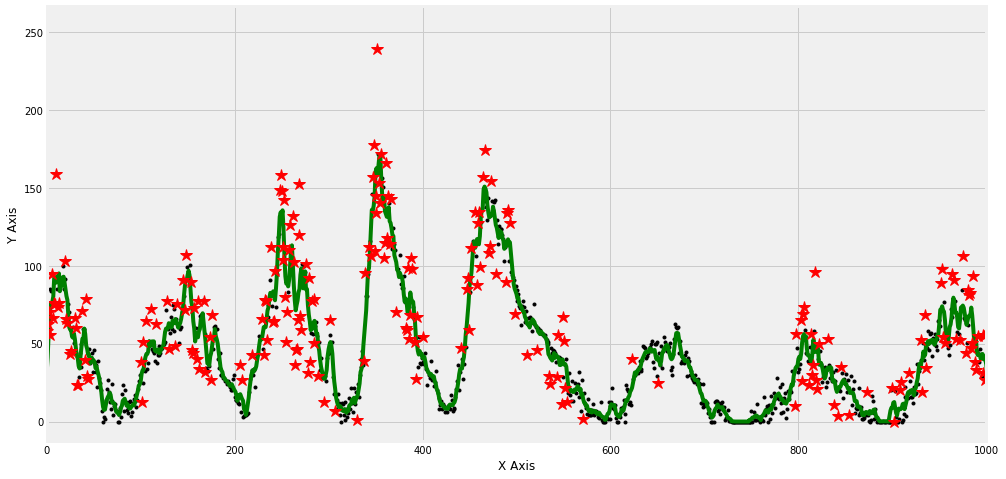

In [22]:
plot_results(data_as_frame['Months'], data_as_frame['SunSpots'], 6, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False)

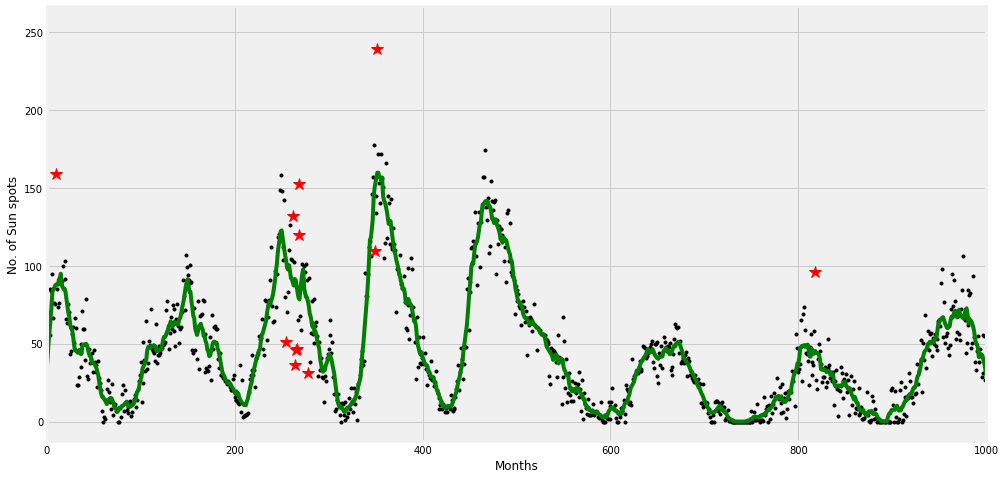

Information about the anomalies model:{'anomalies_dict': OrderedDict([(10, 158.6), (253, 142.5), (255, 51.0), (262, 132.2), (264, 36.0), (268, 152.7), (278, 31.1), (349, 109.3), (352, 238.9), (361, 165.7), (818, 96.2), (986, 93.4), (1055, 206.3), (1069, 84.8), (1172, 107.1), (1182, 52.2), (1185, 180.4), (1464, 88.3), (1735, 129.2), (1882, 107.2), (1890, 103.6), (1897, 108.2), (2023, 154.5), (2025, 72.2), (2027, 129.3), (2171, 108.0), (2274, 165.3), (2380, 201.3), (2390, 94.8), (2391, 189.7), (2503, 158.0), (2518, 152.3), (2520, 217.4), (2521, 143.1), (2527, 199.6), (2755, 58.1), (2756, 138.2), (2789, 90.9), (2807, 127.0), (2885, 196.2), (2886, 126.9), (2897, 105.4), (2899, 200.3), (3005, 137.7), (3018, 170.1), (3032, 150.7)]), 'standard_deviation': 11.424}


In [25]:
 # 4. Lets play with the functions
    
x = data_as_frame['Months']
Y = data_as_frame['SunSpots']

    # plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Months", sigma_value=3,
                text_ylabel="No. of Sun spots")
events = explain_anomalies(Y, window_size=5, sigma=3)

    # Display the anomaly dict
print("Information about the anomalies model:{}".format(events))